In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soheiltehranipour/snappfood-persian-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/snappfood-persian-sentiment-analysis


In [95]:
import pandas as pd
import numpy as np
from collections import defaultdict
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

In [3]:
df = pd.read_csv('/kaggle/input/snappfood-persian-sentiment-analysis/Snappfood - Sentiment Analysis.csv', on_bad_lines='skip')
df.head()

,\tcomment\tlabel\tlabel_id
0,\tواقعا حیف وقت که بنویسم سرویس دهیتون شده افت...
1,\tقرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از ...
2,\tقیمت این مدل اصلا با کیفیتش سازگاری نداره، ف...
3,\tعالللی بود همه چه درست و به اندازه و کیفیت خ...
4,\tشیرینی وانیلی فقط یک مدل بود.\tHAPPY\t0


In [4]:
df.shape

(69759, 1)

In [5]:
df['\tcomment\tlabel\tlabel_id'][3]

'\tعالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم\tHAPPY\t0'

In [6]:
def get_label(text):
    return text.split('\t')[-1]

In [7]:
df['label'] = df['\tcomment\tlabel\tlabel_id'].apply(get_label)

In [8]:
df['label'] = pd.to_numeric(df['label'])

In [9]:
df.head()

,\tcomment\tlabel\tlabel_id,label
0,\tواقعا حیف وقت که بنویسم سرویس دهیتون شده افت...,1
1,\tقرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از ...,0
2,\tقیمت این مدل اصلا با کیفیتش سازگاری نداره، ف...,1
3,\tعالللی بود همه چه درست و به اندازه و کیفیت خ...,0
4,\tشیرینی وانیلی فقط یک مدل بود.\tHAPPY\t0,0


In [10]:
def get_text(text):
    return text.split('\t')[1]

In [11]:
df['text'] = df['\tcomment\tlabel\tlabel_id'].apply(get_text)

In [12]:
df.head()

,\tcomment\tlabel\tlabel_id,label,text
0,\tواقعا حیف وقت که بنویسم سرویس دهیتون شده افت...,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,\tقرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از ...,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...
2,\tقیمت این مدل اصلا با کیفیتش سازگاری نداره، ف...,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...
3,\tعالللی بود همه چه درست و به اندازه و کیفیت خ...,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4,\tشیرینی وانیلی فقط یک مدل بود.\tHAPPY\t0,0,شیرینی وانیلی فقط یک مدل بود.


In [13]:
df.drop(columns = ['\tcomment\tlabel\tlabel_id'], axis = 1, inplace = True)

In [14]:
df.head()

,label,text
0,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...
2,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...
3,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4,0,شیرینی وانیلی فقط یک مدل بود.


In [15]:
df.shape

(69759, 2)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69759 entries, 0 to 69758
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   69759 non-null  int64 
 1   text    69759 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [17]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [18]:
df.duplicated().sum()

519

In [19]:
df.drop_duplicates(inplace = True)

In [20]:
df.shape

(69240, 2)

In [21]:
df['label'].value_counts()

label
0    34798
1    34442
Name: count, dtype: int64

In [22]:
def all_text(text):
    text_list = []
    text_list.append(text)
    return text_list

In [23]:
text_list = df['text'].apply(all_text)

In [24]:
c = df['text']

In [25]:
s = ' '.join(c)

In [26]:
s[:500]

'واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم شیرینی وانیلی فقط یک مدل بود. بدترین پیتزایی که تا به حال خورده بودم از همه لحاظ عالی ممنونم کیفیت غذا متوسط رو ب'

In [27]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = defaultdict(int)
        self.total_words = 0
        self.vcab_size = 0

    def build_vocab(self, sentences, min_count = 2):
        for word in sentences:
            self.word_count[word] += 1

        idx = 0
        for word, count in self.word_count.items():
            if count >= min_count:
                self.word2idx.update({word: idx})
                idx += 1

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
        self.total_words = sum([count for word, count in self.word_count.items() if count >= min_count])

    def word_to_index(self, word):
        return self.word2idx.get(word, -1)

    def index_to_word(self, index):
        return self.idx2word.get(index, None)

In [28]:
def generate_training_data(vocab, sentences, window_size = 2):
    training_data = []
    sentence_indices = [vocab.word_to_index(word) for word in sentences if vocab.word_to_index(word) != -1]

    for center_idx, center_word in enumerate(sentence_indices):
        context_start = max(0, center_idx - window_size)
        context_end = min(len(sentence_indices), center_idx + window_size + 1)

    for context_idx in range(context_start, context_end):
        if context_idx != center_idx:
            context_word = sentence_indices[context_idx]
            training_data.append((center_word, context_word))

    return np.array(training_data)

In [29]:
class Word2Vec:
    def __init__(self, vocab_size, embed_size = 100, learning_rate = 0.001):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.learning_rate = learning_rate

        self.W = np.random.uniform(-0.5, 0.5, (vocab_size, embed_size))
        self.W_prime = np.random.uniform(-0.5, 0.5, (embed_size, vocab_size))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / np.sum(exp_x)

    def train(self, training_data, epochs = 1000):
        for epoch in range(epochs):
            loss = 0
            for center_word, context_word in training_data:
                h = self.W[center_word]
                u = np.dot(h, self.W_prime)
                y_pred = self.softmax(u)

                y_true = np.zeros(self.vocab_size)
                y_true[context_word] = 1

                error = y_pred - y_true

                self.W_prime -= self.learning_rate * np.outer(h, error)
                self.W[center_word] -= self.learning_rate * np.dot(self.W_prime, error)

                loss -= np.log(y_pred[context_word])

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

In [30]:
with open('/kaggle/input/stopwords/persian stop words.txt', 'r', encoding = 'utf-8') as f:
    stopwords = set(f.read().splitlines())

words = s.split()
filtered_text = [word for word in words if word not in stopwords]
cleaned_text = ' '.join(filtered_text)

In [31]:
vocab = Vocabulary()
vocab.build_vocab(cleaned_text.split(' '))
training_data = generate_training_data(vocab, cleaned_text.split(' '))
word2vec_model = Word2Vec(vocab.vocab_size)
word2vec_model.train(training_data, epochs = 1000)

Epoch 0, Loss: 20.172782366579412
Epoch 100, Loss: 17.054702080609875
Epoch 200, Loss: 13.838157999078634
Epoch 300, Loss: 10.300246737104871
Epoch 400, Loss: 6.411349658161126
Epoch 500, Loss: 3.3015684730811135
Epoch 600, Loss: 2.1391023173223314
Epoch 700, Loss: 1.7913021531532576
Epoch 800, Loss: 1.6528551141942958
Epoch 900, Loss: 1.5828115039912514


In [32]:
def get_word_embedding(word, vocab, model):
    word_idx = vocab.word_to_index(word)
    if word_idx != -1:
        return model.W[word_idx]
    else:
        return None

In [33]:
embedding = get_word_embedding('مرد', vocab, word2vec_model)
print(embedding)

[ 0.32898297 -0.03697254 -0.21259771  0.30564344  0.16374046  0.2070302
  0.17230099 -0.43920767  0.43812033 -0.42902081 -0.06893974  0.2143926
  0.01768982 -0.22417929  0.08567398 -0.3453736   0.14553913 -0.04024363
  0.23924791 -0.29344193  0.27135617  0.14289384 -0.24651643 -0.06360783
  0.04420039  0.23647573  0.21766526  0.04900012  0.31581664  0.00779687
 -0.07310151  0.36193181 -0.15943361  0.27325917 -0.47767796  0.07700478
 -0.37037985  0.11848498 -0.15893235 -0.19670517  0.05883892 -0.18701414
 -0.1793843  -0.17649648  0.28190205  0.22510416 -0.28181323 -0.10192627
 -0.28977405  0.00363654  0.14054651 -0.14310072 -0.41401266  0.10779403
 -0.3956071  -0.48017859 -0.222974    0.1901932   0.34989644 -0.02831186
 -0.26985566 -0.28615493 -0.43654958  0.29022335  0.25340152  0.33962494
 -0.30948383 -0.42757284  0.01776788 -0.49612534 -0.4436967  -0.36014174
  0.40150052 -0.05984151 -0.3699667   0.45552262 -0.14012265 -0.18591438
  0.37298642 -0.38689604 -0.09354748  0.30097773 -0.1

In [34]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def find_similar_words(word, vocab, model, k = 5):
    word_idx = vocab.word_to_index(word)

    if word_idx == -1:
        return f"Word '{word}' not in vocabulary."

    word_vector = model.W[word_idx]
    similarities = []

    for idx in range(vocab.vocab_size):
        if idx != word_idx:
            other_word_vector = model.W[idx]
            sim_score = cosine_similarity(word_vector, other_word_vector)
            similarities.append((vocab.index_to_word(idx), sim_score))

    similarities = sorted(similarities, key = lambda x: x[1], reverse = True)

    return similarities[:k]

In [35]:
similar_words = find_similar_words("شیرینی", vocab, word2vec_model, k = 5)
print(similar_words)

[('موتور،', 0.3550338729272685), ('اومده.', 0.34942744445573315), ('متفاوتش', 0.34902955161475313), ('غذاهاشونو', 0.3460078448469231), ('پذیرایی', 0.3337260745598604)]


In [36]:
def clean_stopwords(text):
    words = text.split()
    words2 = [word for word in words if word not in stopwords]
    return ' '.join(words2)

In [37]:
df['cleaned_stop'] = df['text'].apply(clean_stopwords)

In [38]:
df.head()

,label,text,cleaned_stop
0,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,حیف وقت بنویسم سرویس دهیتون افتضاح
1,0,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,قرار ساعته برسه نیم ساعت موقع رسید، ببین چقدرر...
2,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,قیمت مدل کیفیتش سازگاری نداره، ظاهر فریبنده دا...
3,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,عالللی اندازه کیفیت خوب، امیداورم کیفیتتون باش...
4,0,شیرینی وانیلی فقط یک مدل بود.,شیرینی وانیلی مدل بود.


In [39]:
tokenizer = Tokenizer()

In [40]:
tokenizer.fit_on_texts(df['cleaned_stop'])
seq = tokenizer.texts_to_sequences(df['cleaned_stop'])

In [41]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

37600

In [42]:
maxlen = max([len(i) for i in seq])
maxlen

189

In [43]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [44]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = get_word_embedding(word, vocab, word2vec_model)
    if vec is not None:
        embedding_vectors[index] = vec

In [45]:
embedding_vectors[1000:1003]

array([[ 0.22354837,  0.08864501, -0.21694999,  0.19744552,  0.48086333,
         0.45694083,  0.03600066,  0.33188791,  0.10653334,  0.45852328,
         0.02570296, -0.18205201,  0.09684419, -0.42759156,  0.47872826,
         0.38023239,  0.49604807,  0.02051988, -0.41429832, -0.14357954,
        -0.03404351,  0.35543942,  0.46182324, -0.27488591, -0.29018102,
        -0.29874965, -0.30886685, -0.47017691,  0.24074777,  0.22612403,
        -0.26084647, -0.20721841, -0.36730673, -0.27086161,  0.28693601,
         0.12253313, -0.14826618, -0.09981521,  0.47145087, -0.36507869,
        -0.46569844, -0.09779015,  0.11744065,  0.30912826,  0.37107762,
         0.49642304,  0.19012893, -0.00050846, -0.12474855, -0.00606171,
         0.45769617, -0.21526093, -0.24300859,  0.4566368 , -0.49604195,
        -0.12218688,  0.25595238, -0.12942711, -0.39499781, -0.41608883,
         0.27845837, -0.15177705, -0.10513502,  0.15450312, -0.47188678,
        -0.49855719, -0.01003426,  0.33250089,  0.0

In [46]:
y = df['label']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.2, random_state = 101, stratify = y)

In [53]:
model_lstm = Sequential()

In [54]:
model_lstm.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model_lstm.add(Bidirectional(LSTM(15)))
model_lstm.add(Dense(1, activation = 'sigmoid'))

In [55]:
model_lstm.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [56]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [57]:
history = model_lstm.fit(X_train, y_train, validation_split = 0.1, epochs = 100, callbacks = [early_stopping], batch_size = 64)

Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6789 - loss: 0.5849 - val_accuracy: 0.7509 - val_loss: 0.4947
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7574 - loss: 0.4836 - val_accuracy: 0.7655 - val_loss: 0.4697
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7800 - loss: 0.4529 - val_accuracy: 0.7827 - val_loss: 0.4493
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7931 - loss: 0.4356 - val_accuracy: 0.7874 - val_loss: 0.4402
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8017 - loss: 0.4222 - val_accuracy: 0.7881 - val_loss: 0.4340
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8096 - loss: 0.4122 - val_accuracy: 0.7948 - val_loss: 0.4298
Epoch 7/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8128 - loss: 0.4040 - val_accuracy: 0.7940 - val_loss: 0.4303
Epoch 8/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8173 - loss: 0

In [62]:
def plot_results(train_accs, train_losses, valid_accs, valid_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = 'Train')
    axes[0].plot(xs, valid_accs, label = 'Validation')
    axes[0].set_title('Accuracy', fontsize = 15)
    axes[0].set_xlabel('Epoch', fontsize = 10)
    axes[0].set_ylabel('Accuracy', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_losses, label = 'Train')
    axes[1].plot(xs, valid_losses, label = 'Validation')
    axes[1].set_title('Loss', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Loss', fontsize = 10)
    axes[1].set_xticks(xs)
    plt.tight_layout()
    axes[0].legend()
    axes[1].legend()
    plt.show()

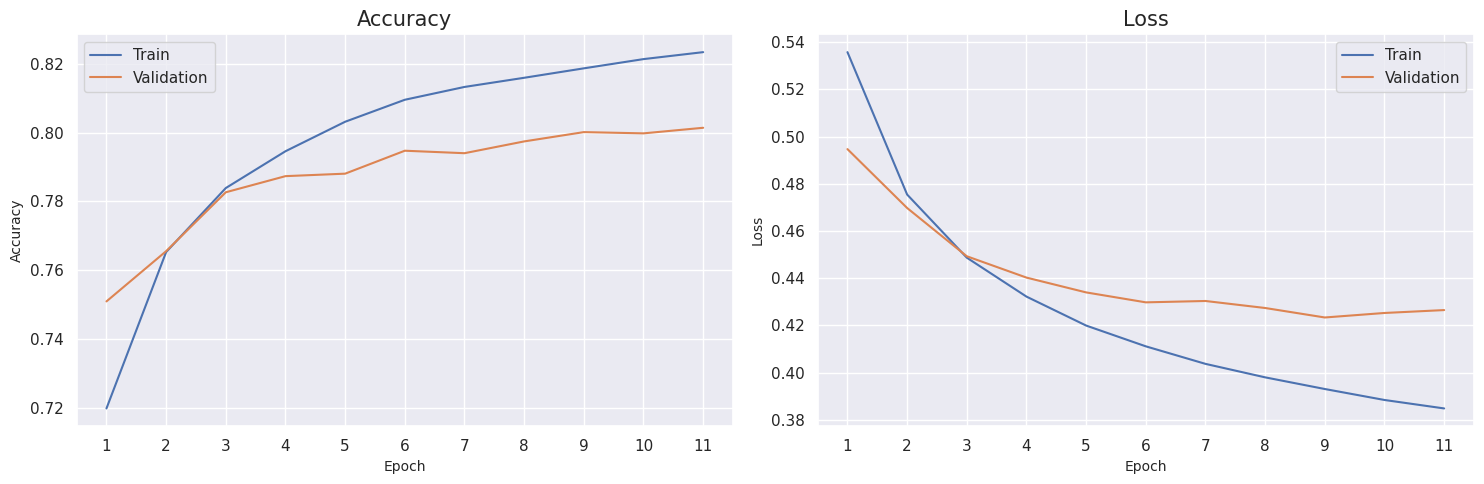

In [65]:
plot_results(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

In [66]:
model_lstm2 = Sequential()

In [67]:
model_lstm2.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model_lstm2.add(Bidirectional(LSTM(15)))
model_lstm2.add(BatchNormalization())
model_lstm2.add(Dense(1, activation = 'sigmoid'))

In [68]:
model_lstm2.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [69]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [70]:
history2 = model_lstm2.fit(X_train, y_train, validation_split = 0.1, epochs = 100, callbacks = [early_stopping2], batch_size = 64)

Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6849 - loss: 0.5804 - val_accuracy: 0.7606 - val_loss: 0.4848
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7719 - loss: 0.4661 - val_accuracy: 0.7702 - val_loss: 0.4598
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7883 - loss: 0.4410 - val_accuracy: 0.7231 - val_loss: 0.5203
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7952 - loss: 0.4291 - val_accuracy: 0.7928 - val_loss: 0.4332
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7992 - loss: 0.4218 - val_accuracy: 0.7903 - val_loss: 0.4424
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8053 - loss: 0.4104 - val_accuracy: 0.7991 - val_loss: 0.4284
Epoch 7/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8115 - loss: 0.4034 - val_accuracy: 0.8004 - val_loss: 0.4259
Epoch 8/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8167 - loss: 0

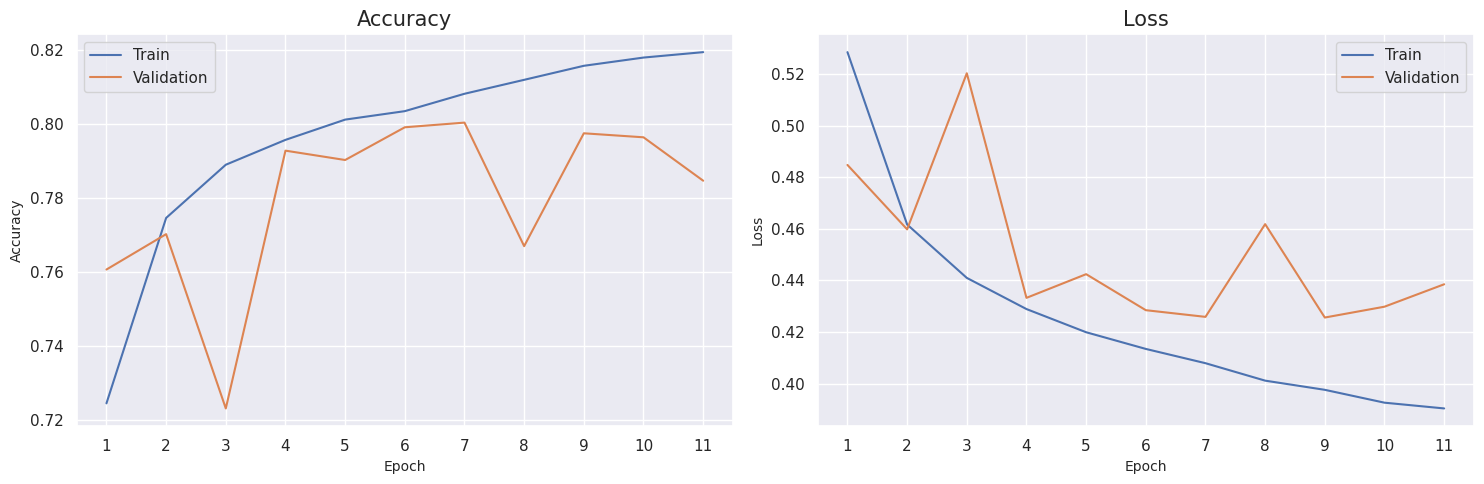

In [71]:
plot_results(history2.history['accuracy'], history2.history['loss'], history2.history['val_accuracy'], history2.history['val_loss'])

In [72]:
model_lstm3 = Sequential()

In [73]:
model_lstm3.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model_lstm3.add(Bidirectional(LSTM(15)))
model_lstm3.add(Dropout(0.25))
model_lstm3.add(Dense(1, activation = 'sigmoid'))

In [74]:
model_lstm3.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [75]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [76]:
history3 = model_lstm3.fit(X_train, y_train, validation_split = 0.1, epochs = 100, callbacks = [early_stopping3], batch_size = 64)

Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6772 - loss: 0.5899 - val_accuracy: 0.7498 - val_loss: 0.4944
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7607 - loss: 0.4845 - val_accuracy: 0.7664 - val_loss: 0.4753
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7747 - loss: 0.4647 - val_accuracy: 0.7789 - val_loss: 0.4553
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7852 - loss: 0.4455 - val_accuracy: 0.7892 - val_loss: 0.4450
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7935 - loss: 0.4348 - val_accuracy: 0.7881 - val_loss: 0.4395
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7973 - loss: 0.4292 - val_accuracy: 0.7946 - val_loss: 0.4363
Epoch 7/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8050 - loss: 0.4198 - val_accuracy: 0.7921 - val_loss: 0.4398
Epoch 8/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8026 - loss: 0

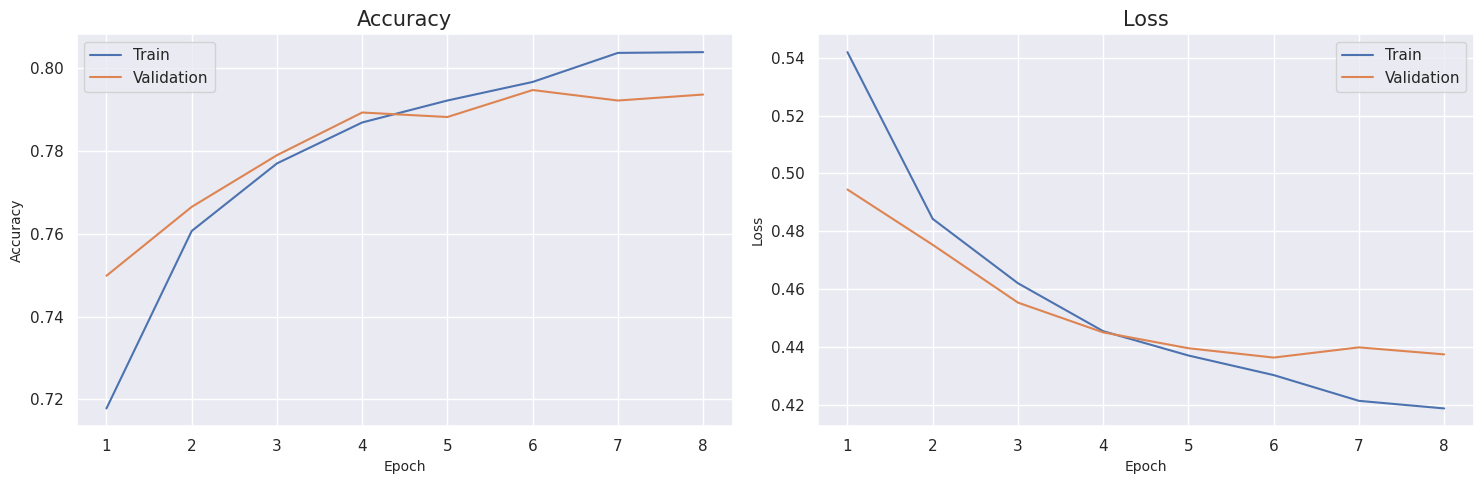

In [77]:
plot_results(history3.history['accuracy'], history3.history['loss'], history3.history['val_accuracy'], history3.history['val_loss'])

In [78]:
model_lstm4 = Sequential()

In [79]:
model_lstm4.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model_lstm4.add(Bidirectional(LSTM(15)))
model_lstm4.add(BatchNormalization())
model_lstm4.add(Dropout(0.25))
model_lstm4.add(Dense(1, activation = 'sigmoid'))

In [80]:
model_lstm4.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [81]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [82]:
history4 = model_lstm4.fit(X_train, y_train, validation_split = 0.1, epochs = 100, callbacks = [early_stopping4], batch_size = 64)

Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6692 - loss: 0.5984 - val_accuracy: 0.7480 - val_loss: 0.4929
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7614 - loss: 0.4856 - val_accuracy: 0.7606 - val_loss: 0.4644
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7802 - loss: 0.4567 - val_accuracy: 0.7756 - val_loss: 0.4602
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7879 - loss: 0.4477 - val_accuracy: 0.7899 - val_loss: 0.4370
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7947 - loss: 0.4337 - val_accuracy: 0.7912 - val_loss: 0.4379
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8007 - loss: 0.4280 - val_accuracy: 0.7913 - val_loss: 0.4394


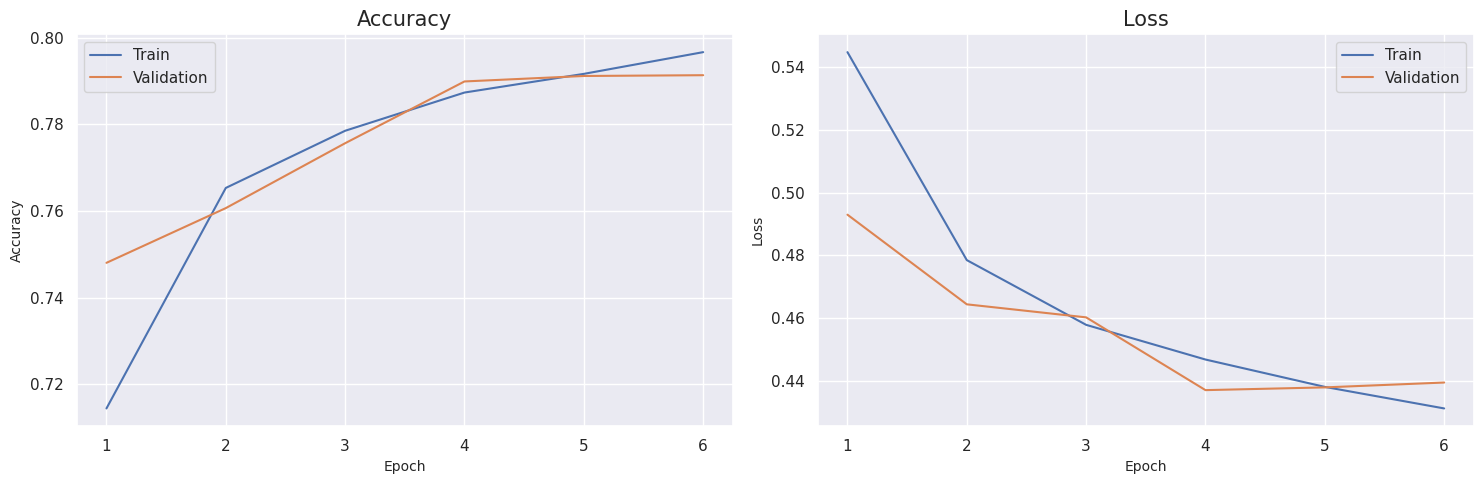

In [83]:
plot_results(history4.history['accuracy'], history4.history['loss'], history4.history['val_accuracy'], history4.history['val_loss'])

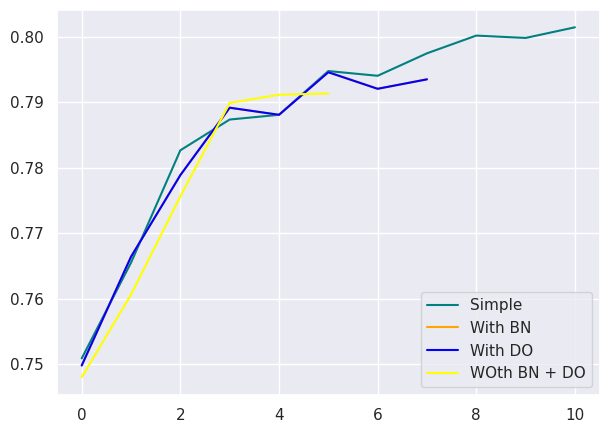

In [90]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_accuracy'], label = 'Simple', color = 'teal')
plt.plot(history3.history['val_accuracy'], label = 'With BN', color = 'orange')
plt.plot(history3.history['val_accuracy'], label = 'With DO', color = 'blue')
plt.plot(history4.history['val_accuracy'], label = 'WOth BN + DO', color = 'yellow')
plt.legend()
plt.show()

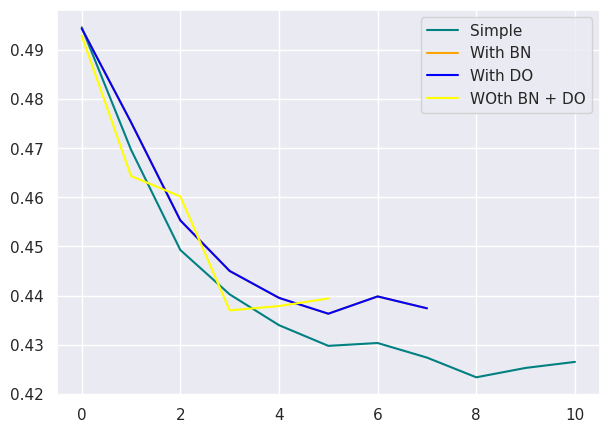

In [91]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'], label = 'Simple', color = 'teal')
plt.plot(history3.history['val_loss'], label = 'With BN', color = 'orange')
plt.plot(history3.history['val_loss'], label = 'With DO', color = 'blue')
plt.plot(history4.history['val_loss'], label = 'WOth BN + DO', color = 'yellow')
plt.legend()
plt.show()

In [92]:
model_lstm.evaluate(X_test, y_test)

433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7969 - loss: 0.4309


[0.42787545919418335, 0.7995378375053406]

In [93]:
y_p = model_lstm.predict(X_test)

433/433 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [94]:
y_pred = np.where(y_p > 0.5, 1, 0)

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.77      0.79      6960
           1       0.78      0.83      0.81      6888

    accuracy                           0.80     13848
   macro avg       0.80      0.80      0.80     13848
weighted avg       0.80      0.80      0.80     13848



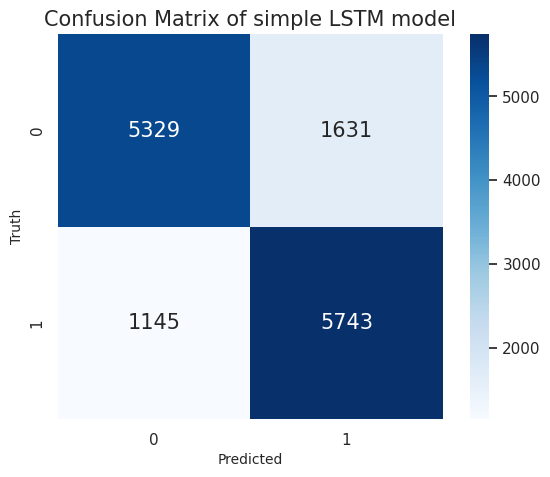

In [97]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cbar = True, square = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix of simple LSTM model', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [112]:
while True:
    te = input('Comment: ')
    if te == 'finish':
        break
    else:
        te_seq = tokenizer.texts_to_sequences([te])[0]
        pad_te = pad_sequences([te_seq], maxlen = maxlen, padding = 'post')
        f = model_lstm.predict(pad_te)
        g = np.where(f > 0.5, 1, 0)
        print(te)
        if g == 0:
            print('نظر شما مثبت بود')
        else:
            print('نظر شما منفی بود')
            print('==========================================================')

Comment:  پشتیبانی بشدت ضعیف چندین بار غذا سفارش دادم هربار به یه مشکلی برخورد


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
پشتیبانی بشدت ضعیف چندین بار غذا سفارش دادم هربار به یه مشکلی برخورد
نظر شما منفی بود


Comment:  وقتی تنها اپلیکیشنی هست که میشه آنلاین غذا سفارش داد معلومه چی میشه! رستوران های خوبی نداره، مشکل اپلیکیشن داره و قطع هست، پشتیبانی متاسفانه بدی داره و فقط میگن نمیشه! باور کنید یک اپلیکیشن دیگه ای بود قطعا اسنپ رو پاک میکردم.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
وقتی تنها اپلیکیشنی هست که میشه آنلاین غذا سفارش داد معلومه چی میشه! رستوران های خوبی نداره، مشکل اپلیکیشن داره و قطع هست، پشتیبانی متاسفانه بدی داره و فقط میگن نمیشه! باور کنید یک اپلیکیشن دیگه ای بود قطعا اسنپ رو پاک میکردم.
نظر شما منفی بود


Comment:  خیلی خوبه


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
خیلی خوبه
نظر شما مثبت بود


Comment:  سلام .من کالای پروتئینی تهیه کردم تازه سوسیس با بسته بندی شرکتی بود متاسفانه کالای فوق دارای هیچ تاریخ تولید و انقضایی نبود بعد از پیگیری فراوان باجمله متاسفیم فروشنده قبول نمی‌کند و کاری از دست ما بر نمی آید رو به رو شدم کلا پشتیبانی ضعیف دارد همچون اسنپ خودرو به هیچ وجه و هرگز پیشنهاد نمیکنم


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
سلام .من کالای پروتئینی تهیه کردم تازه سوسیس با بسته بندی شرکتی بود متاسفانه کالای فوق دارای هیچ تاریخ تولید و انقضایی نبود بعد از پیگیری فراوان باجمله متاسفیم فروشنده قبول نمی‌کند و کاری از دست ما بر نمی آید رو به رو شدم کلا پشتیبانی ضعیف دارد همچون اسنپ خودرو به هیچ وجه و هرگز پیشنهاد نمیکنم
نظر شما منفی بود


Comment:  باید بسیار بهتر شود. مشکلات زیادی در تحویل وجود دارد.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
باید بسیار بهتر شود. مشکلات زیادی در تحویل وجود دارد.
نظر شما مثبت بود


Comment:  ا سلام و خسته نباشید. خیلی ها هم هنوز طرزاستفاده ازبرنامه فودرا بلد نیستند. وهمچنان برای سفارش در اسنپ فود و … فکر می‌کنند کرایه مبلغ بالا باید پرداخت کنند ویدئو آموزشی یا تیزر تبلیغاتی ازطریق تلوزیون یا رسانه ها بسیار موثراست برای جذب مشتری


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
ا سلام و خسته نباشید. خیلی ها هم هنوز طرزاستفاده ازبرنامه فودرا بلد نیستند. وهمچنان برای سفارش در اسنپ فود و … فکر می‌کنند کرایه مبلغ بالا باید پرداخت کنند ویدئو آموزشی یا تیزر تبلیغاتی ازطریق تلوزیون یا رسانه ها بسیار موثراست برای جذب مشتری
نظر شما مثبت بود


Comment:  با کد تخفیف هایی که سایت آفارو میده از اسنپ فود هم غذا و هم میوه و شیرینی و نان و گوشت و خرید سوپرمارکتی میکنم ، به طور کلی راضیم هرچند کیفیت همه فروشگاه هاشون عالی نیست ولی خوب توشن زیاده و به جز بعضی روزا که پیک کم دارن بقیه روزا سریع میرسه در کل از نظر کیفیت و زمان ارسال ۹۰% راضیم ، قیمت هم با تخفیف و کد تخفیف خوبه ولی بدون تخفیف نمیصرفه


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
با کد تخفیف هایی که سایت آفارو میده از اسنپ فود هم غذا و هم میوه و شیرینی و نان و گوشت و خرید سوپرمارکتی میکنم ، به طور کلی راضیم هرچند کیفیت همه فروشگاه هاشون عالی نیست ولی خوب توشن زیاده و به جز بعضی روزا که پیک کم دارن بقیه روزا سریع میرسه در کل از نظر کیفیت و زمان ارسال ۹۰% راضیم ، قیمت هم با تخفیف و کد تخفیف خوبه ولی بدون تخفیف نمیصرفه
نظر شما مثبت بود


Comment:  finish
